# **Segmentation of Top**

In [1]:
%cd /content/
!rm -rf cloth-segmentation
!git clone https://github.com/levindabhi/cloth-segmentation.git
%cd cloth-segmentation
!gdown --id 1mhF3yqd7R-Uje092eypktNl-RoZNuiCJ
!mkdir input_images
!mkdir output_images

/content
Cloning into 'cloth-segmentation'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 62 (delta 4), reused 53 (delta 2), pack-reused 6
Unpacking objects: 100% (62/62), done.
/content/cloth-segmentation
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1mhF3yqd7R-Uje092eypktNl-RoZNuiCJ
To: /content/cloth-segmentation/cloth_segm_u2net_latest.pth
100% 177M/177M [00:00<00:00, 228MB/s]


In [2]:
!pip install networks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for networks: filename=networks-0.3.7-py3-none-any.whl size=11659 sha256=67a32835ff7fcbeee4f1d1347fd927a4acc279c7603b5c73f087b201f88aebcd
  Stored in directory: /root/.cache/pip/wheels/6e/6d/ca/907ecfc53d146112dd059a61130ae0e50efea5fa3afe4b456a
Successfully built networks


In [5]:
import os
# from tqdm import tqdm
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

from data.base_dataset import Normalize_image
from utils.saving_utils import load_checkpoint_mgpu

from networks import U2NET
device = 'cuda'

image_dir = '/content/Input'
result_dir = '/content/'
checkpoint_path = '/content/drive/MyDrive/cloth_segm_u2net_latest.pth'

def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    return palette


transforms_list = []
transforms_list += [transforms.ToTensor()]
transforms_list += [Normalize_image(0.5, 0.5)]
transform_rgb = transforms.Compose(transforms_list)

net = U2NET(in_ch=3, out_ch=4)
net = load_checkpoint_mgpu(net, checkpoint_path)
net = net.to(device)
net = net.eval()

palette = get_palette(4)

!rm -rf input_images/.ipynb_checkpoints
images_list = sorted(os.listdir(image_dir))
pbar = tqdm(total=len(images_list))
for image_name in images_list:
    img = Image.open(os.path.join(image_dir, image_name)).convert('RGB')
    img_size = img.size
    img = img.resize((768, 768), Image.BICUBIC)
    image_tensor = transform_rgb(img)
    image_tensor = torch.unsqueeze(image_tensor, 0)
    
    output_tensor = net(image_tensor.to(device))
    output_tensor = F.log_softmax(output_tensor[0], dim=1)
    output_tensor = torch.max(output_tensor, dim=1, keepdim=True)[1]
    output_tensor = torch.squeeze(output_tensor, dim=0)
    output_tensor = torch.squeeze(output_tensor, dim=0)
    output_arr = output_tensor.cpu().numpy()

    output_img = Image.fromarray(output_arr.astype('uint8'), mode='L')
    output_img = output_img.resize(img_size, Image.BICUBIC)
    
    output_img.putpalette(palette)
    output_img.save(os.path.join(result_dir, image_name[:-4]+'_generated.png'))
    
    pbar.update(1)

pbar.close()

----checkpoints loaded from path: /content/drive/MyDrive/cloth_segm_u2net_latest.pth----


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [6]:
!rm -rf output_images/*

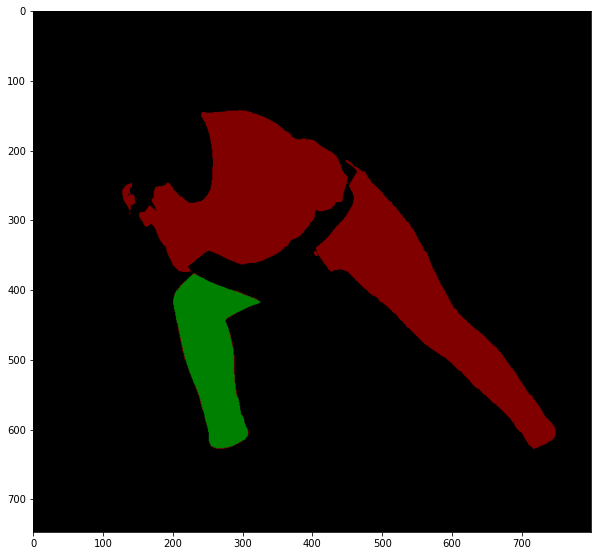

In [12]:
import cv2
import matplotlib.pyplot as plt

result = cv2.imread("/content/1.png")
result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
plt.figure(figsize = (10,10))
plt.imshow(result)
plt.show()

# **End of Segmentation Program**